## 初始設定
連結雲端位置、載入套件

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip install arch
import numpy as np
from scipy.optimize import fsolve
from scipy.special import gamma
import pandas as pd
from scipy.optimize import minimize
import yfinance as yf
# from arch.unitroot import ADF
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sympy import symbols,exp,log,factorial, sqrt
from sympy.utilities.lambdify import lambdify
import scipy.optimize as optimize
from datetime import datetime

In [ ]:
root = '/content/drive/MyDrive/Colab Notebooks/TMBA'

In [ ]:
# import yfinance as yf
# from datetime import datetime

# # 匯入論文的 PEP 和 KO

# # 定義開始和結束日期
# start_date = datetime(2009, 11, 30)
# end_date = datetime(2012, 11, 30)

# stock_data = []
# stock_name = ['PEP', 'KO']

# # 載入 PEP KO 的股價資料
# PEP_data = yf.download('PEP', start=start_date, end=end_date)
# KO_data = yf.download('KO', start=start_date, end=end_date)

# PEP_data.reset_index(inplace=True)
# KO_data.reset_index(inplace=True)

# stock_data.append(PEP_data)
# stock_data.append(KO_data)

# # 顯示前幾筆資料
# print("PEP-KO 股價資料:")
# for i in stock_data:
#   print(i.head())

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
PEP-KO 股價資料:
        Date       Open       High        Low      Close  Adj Close   Volume
0 2009-11-30  62.639999  62.830002  62.150002  62.220001  41.104286  7252700
1 2009-12-01  62.680000  63.930000  62.490002  63.869999  42.194317  6887700
2 2009-12-02  63.500000  63.740002  63.169998  63.650002  42.347340  6195800
3 2009-12-03  63.580002  63.590000  62.669998  62.759998  41.755211  6406200
4 2009-12-04  63.180000  64.000000  63.080002  63.849998  42.480400  8907000
        Date       Open       High        Low      Close  Adj Close    Volume
0 2009-11-30  28.645000  28.660000  28.400000  28.600000  18.549906  18884800
1 2009-12-01  28.795000  29.129999  28.690001  29.040001  18.835287  15359800
2 2009-12-02  28.915001  29.100000  28.840000  28.980000  18.796370  13599400
3 2009-12-03  29.045000  29.045000  28.580000  28.635000  18.572615  202418

In [ ]:
# for i in stock_data:
#   i['log_price'] = np.log(i['Close'])
#   i['log_ret'] = i['log_price'] - i['log_price'].iloc[0]
#   i = i.dropna()

## 匯入共整合 ADF 篩選的資料

In [ ]:
stock_data = []
stock_name_list_1 = []
stock_name_list_2 = []
stock_pair = pd.read_csv(f"{root}/dataset/stock_pair.csv")
stock_name_list_1.append(stock_pair['stock_pair'][0][0:3])
stock_name_list_2.append(stock_pair['stock_pair'][0][8:12])

for i in stock_name_list_1:
  stock_data.append(pd.read_csv(f"{root}/dataset/{i}.csv"))

for i in stock_name_list_2:
  stock_data.append(pd.read_csv(f"{root}/dataset/{i}.csv"))

print(stock_data)

In [ ]:
X = sm.add_constant(stock_data[0]['log_ret'])
Y = stock_data[1]['log_ret']
result = sm.OLS(Y, X).fit()
beta = result.params[1]
X_t = stock_data[1]['log_price'] - beta * stock_data[0]['log_price']
print(X_t)

0     -2.946511
1     -2.971162
2     -2.967967
3     -2.958467
4     -2.980894
         ...   
751   -2.848001
752   -2.859009
753   -2.859799
754   -2.861276
755   -2.849552
Name: log_price, Length: 756, dtype: float64


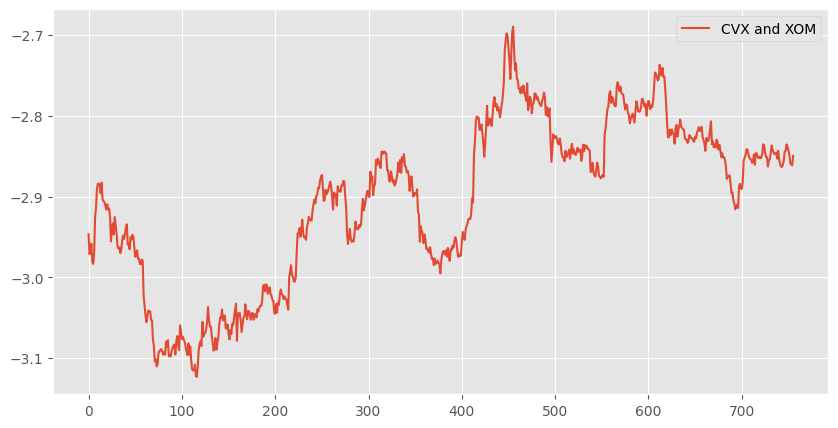

In [ ]:
fig,ax = plt.subplots(1, figsize = (10, 5))
ax.plot(X_t, label = stock_pair['stock_pair'][0])
ax.grid('True')
ax.legend()
plt.show()

## 最大化對數概似函數L(X|μ, θ, σ)

In [ ]:
n = X_t.shape[0]
dt = 1/n
mu = X_t.mean()
theta = symbols('theta')
sigma = symbols('sigma')
inf = float('inf')

In [ ]:
log_likelihood_cum_1 = 0
log_likelihood_cum_2 = 0
for i in range(1, n-1):
  log_likelihood_cum_1 = log_likelihood_cum_1 + log(1 - exp(-2 * theta * dt))
  log_likelihood_cum_2 = log_likelihood_cum_2 + (X_t[i] - mu - (X_t[i-1] - mu) * exp(-theta * dt)) / (1 - exp(-2 * theta * dt))
log_likelihood = (-1 * n/2 - 0.5 * log_likelihood_cum_1 - (theta/sigma**2) * log_likelihood_cum_2)*(-1)
log_likelihood = lambdify((theta, sigma), log_likelihood)

In [ ]:
fun_method = 'Powell' #’Nelder-Mead’
def equation(x):
  theta = x[0]
  sigma = x[1]
  return abs(log_likelihood(theta, sigma))
init = np.array([0.001, 0.01])
bnds = ((0, inf), (0, inf))
sol = optimize.minimize(equation, x0 = init, bounds=bnds, method = fun_method, options = {"disp": False})

theta = sol.x[0]
sigma = sol.x[1]
print(f'mu = {mu}, theta = {theta}, sigma = {sigma}')

mu = -2.9046334890630816, theta = 6.41796267467233e-05, sigma = 0.07656098265471563


<lambdifygenerated-3>:2: RuntimeWarning: divide by zero encountered in log
  return 377.0*log(1 - exp(-0.00264550264550265*theta)) + 378.0 + theta*((-0.218403759668212 + 0.217617722271785*exp(-0.00132275132275132*theta))/(1 - exp(-0.00264550264550265*theta)) + (-0.217617722271785 + 0.203312354139664*exp(-0.00132275132275132*theta))/(1 - exp(-0.00264550264550265*theta)) + (-0.21059650784473 + 0.209303545057647*exp(-0.00132275132275132*theta))/(1 - exp(-0.00264550264550265*theta)) + (-0.209939366124902 + 0.21059650784473*exp(-0.00132275132275132*theta))/(1 - exp(-0.00264550264550265*theta)) + (-0.209303545057647 + 0.198102840854245*exp(-0.00132275132275132*theta))/(1 - exp(-0.00264550264550265*theta)) + (-0.206752744305202 + 0.218403759668212*exp(-0.00132275132275132*theta))/(1 - exp(-0.00264550264550265*theta)) + (-0.205480688615669 + 0.19658586003194*exp(-0.00132275132275132*theta))/(1 - exp(-0.00264550264550265*theta)) + (-0.203312354139664 + 0.209939366124902*exp(-0.00132275132275132

## New Optimal Trading Rule 閥值計算

In [ ]:
a = symbols('a')
b = 0
c = 0.02

In [ ]:
c_tilde = c * (sigma / (2 * theta)**0.5)

In [ ]:
equation = 0
for n in range(0, 100):
  equation += (a-c) * (sqrt(2)/2) * (sqrt(2)*a)**(2*n)/factorial(2*n) * factorial(n + 0.5)
neg_equation = -equation
neg_equation = lambdify(a, neg_equation)

In [ ]:
def equation_1(x):
    a = x[0]
    return abs(neg_equation(a))

init_1 = 10
sol_1 = optimize.minimize(equation_1, x0 = init_1, method = fun_method)

a = sol_1.x[0]
print(f'a = {a}, b = {b}, c = {c}')

a = 0.019999999999999997, b = 0, c = 0.02


In [ ]:
a_1_tilde = a * (sigma / (2 * theta)**0.5) + mu
a_2_tilde = -a * (sigma / (2 * theta)**0.5) + mu
b_tilde = b * (sigma / (2 * theta)**0.5) + mu
print(f'a_tilde = {a_1_tilde}, a_tilde_2 = {a_2_tilde}, b_tilde = {b_tilde}, c_tilde = {c_tilde}')

a_tilde = -2.7694810451590404, a_tilde_2 = -3.039785932967123, b_tilde = -2.9046334890630816, c_tilde = 0.13515244390404138


In [ ]:
res = pd.DataFrame({
    'mu': [mu],
    'theta': [theta],
    'sigma': [sigma],
    'a': [a], 'b': [b], 'c': [c],
    'a_tilde': [a_1_tilde], 'a_tilde_2': [a_2_tilde], 'b_tilde': [b_tilde],
    'c_tilde': [c_tilde]})

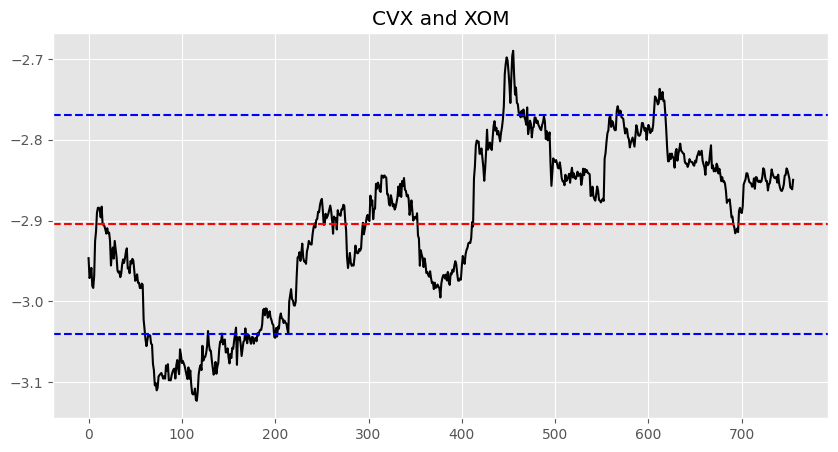

In [ ]:
fig,ax = plt.subplots(1, figsize = (10, 5))
ax.plot(X_t, label = 'True spread', color = 'black')
ax.set_title(stock_pair['stock_pair'][0])
ax.axhline(y = a_1_tilde, color = 'blue', linestyle = '--', label = 'a_tilde_1')
ax.axhline(y = a_2_tilde, color = 'blue', linestyle = '--', label = 'a_tilde_2')
ax.axhline(y = b_tilde, color = 'red', linestyle = '--', label = 'b_tilde')
ax.grid('True')
plt.show()

## 交易策略

In [ ]:
df_close = pd.DataFrame()
spreads = X_t
df_close['close_y'] = stock_data[0]['Close']
df_close['close_x'] = stock_data[1]['Close']
money = 1000000
beta = beta
a_1 = a_1_tilde
a_2 = a_2_tilde
b = b_tilde
c = c_tilde

In [ ]:
signal_in = np.zeros(len(spreads))
signal_out = np.zeros(len(spreads))
position = np.zeros(len(spreads))

for i in range(1, len(spreads)-1):
    if i == len(spreads)-1:
        break
    if position[i] == 0 :
        if (spreads.iloc[i] > a_1) and (spreads.iloc[i-1] < a_1):
            signal_in[i] = 1
            position[i+1] = 1
        elif (spreads.iloc[i] < a_2) and (spreads.iloc[i-1] > a_2):
            signal_in[i] = -1
            position[i+1] = -1
    elif position[i] == 1 :
        if (spreads.iloc[i] < b) and (spreads.iloc[i-1] > b):
            signal_out[i] = 1
            position[i+1] = 0
        else:
            position[i+1] = 1
    elif position[i] == -1 :
        if (spreads.iloc[i] > b) and (spreads.iloc[i-1] <b):
            signal_out[i] = -1
            position[i+1] = 0
        else:
            position[i+1] = -1

## 回測

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
751   -0.250048
752   -0.250048
753   -0.250048
754   -0.250048
755   -0.250048
Length: 756, dtype: float64


<function matplotlib.pyplot.show(close=None, block=None)>

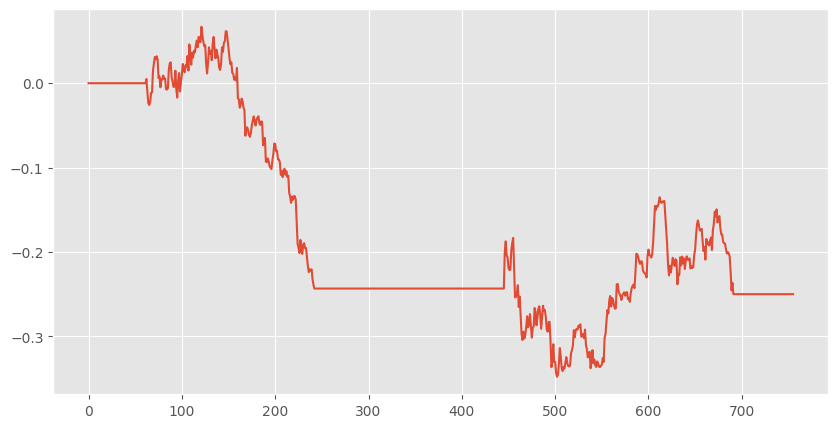

In [ ]:
ret_1 = df_close['close_y'].pct_change().fillna(0)
ret_2 = df_close['close_x'].pct_change().fillna(0)
returns = np.zeros(len(df_close.index.unique()))
n = 0
try:
    ret = ret_1*position*(-1) + ret_2*position*beta #- c*abs(position)
    n+=1
    returns = returns + ret
except:
    pass
returns = returns/n

print(returns.cumsum())
plt.figure(figsize = (10, 5))
plt.plot(returns.cumsum())
plt.show

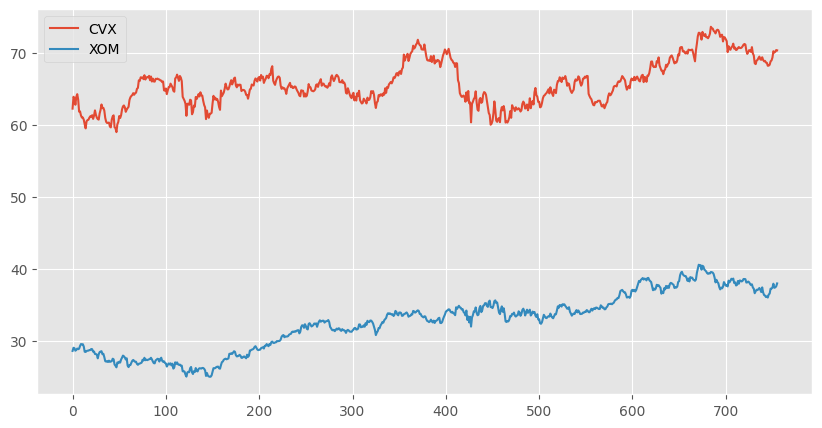

In [ ]:
plt.figure(figsize = (10, 5))
plt.plot(df_close['close_y'], label = stock_pair['stock_pair'][0][0:3])
plt.plot(df_close['close_x'], label = stock_pair['stock_pair'][0][8:12])
plt.legend()
plt.grid(True)
plt.show()

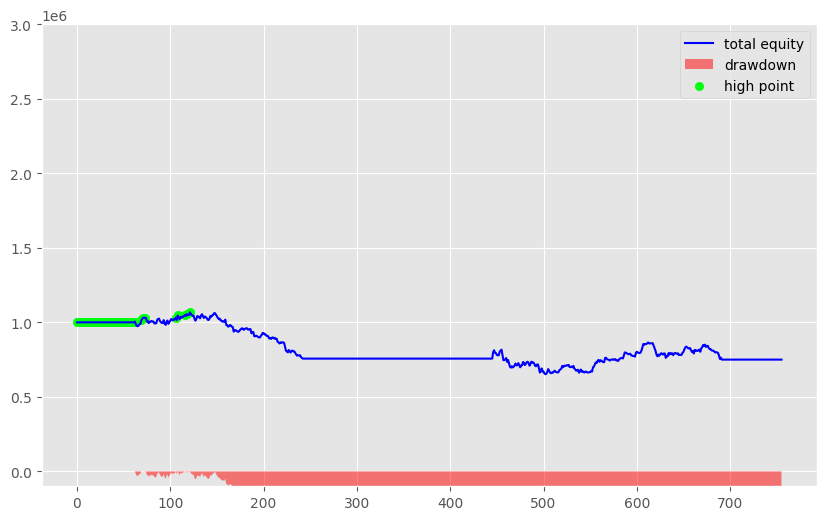

In [ ]:
full_equity_sum = money * (1 + returns.cumsum())
dd = full_equity_sum - full_equity_sum.cummax()
high_index = full_equity_sum[full_equity_sum == full_equity_sum.cummax()].index

fig, ax = plt.subplots(figsize = (10, 6))
full_equity_sum.plot(label = 'total equity', ax = ax, color = 'blue', grid = True, ylim = (-0.1e6, 3e6))
plt.fill_between(dd.index, dd, 0, facecolor = 'red', alpha = 0.5, label = 'drawdown')
plt.scatter(high_index, full_equity_sum[high_index], color = '#02ff0f', label = 'high point')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Spread Movement')

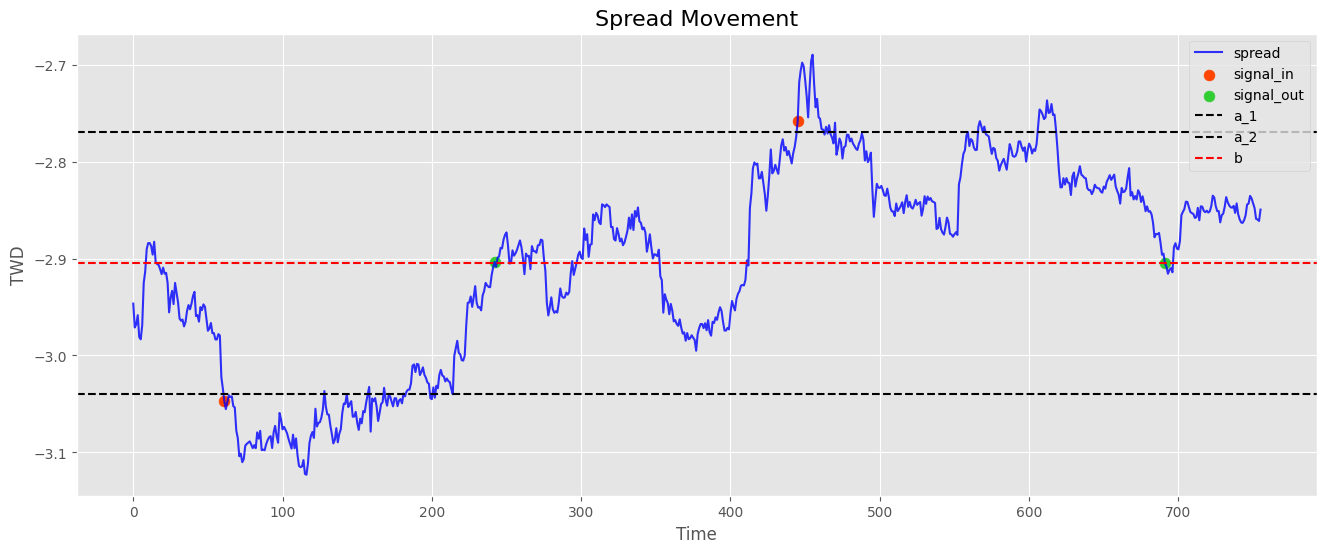

In [ ]:
dd.min()
mdd = dd.min()/money


fig, ax = plt.subplots(figsize = (16,6))
plt.style.use('ggplot')
spreads.plot(label = 'spread', ax = ax, c = 'blue', grid = True, alpha = 0.8)
plt.scatter(spreads.iloc[signal_in != 0].index, spreads.iloc[signal_in != 0], c = 'orangered', label = 'signal_in', marker = 'o', s = 60)
plt.scatter(spreads.iloc[signal_out != 0].index, spreads.iloc[signal_out != 0], c = 'limegreen', label = 'signal_out', marker = 'o', s = 60)
plt.axhline(a_1, c = 'black', ls = '--', label = 'a_1')
plt.axhline(a_2, c = 'black', ls = '--', label = 'a_2')
plt.axhline(b, c = 'red', ls = '--', label = 'b')
plt.legend()
plt.ylabel('TWD')
plt.xlabel('Time')
plt.title('Spread Movement',fontsize  = 16)